In [12]:
from laughter_classification.sspnet_data_sampler import SSPNetDataSampler
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from torch import optim
import torch.nn as nn
from sklearn.model_selection import train_test_split
from laughter_prediction.predictors import RnnPredictor

In [ ]:
s = SSPNetDataSampler('.')
_ = s.create_sampled_df(0.1, save_path='dataset_all.csv', force_save=True)

In [16]:
class LaughClassifier(nn.Module):
    def __init__(self, input1, input2, hidden1, hidden2):
        super(LaughClassifier, self).__init__()

        self.input1 = input1
        self.hidden1 = hidden1
        self.gru1 = nn.GRU(input1, hidden1, 1)
        self.fc1 = nn.Linear(hidden1, 2)
        self.input2 = input2
        self.hidden2 = hidden2
        self.gru2 = nn.GRU(input2, hidden2, 1)
        self.fc2 = nn.Linear(hidden1 + hidden2, 2)
        self.clear()

    def clear(self):
        self.h1 = torch.zeros(1, 1, self.hidden1)
        self.h2 = torch.zeros(1, 1, self.hidden2)

    def forward(self, X):
        gru1, _ = self.gru1(X[0], self.h1)
        out1 = self.fc1(gru1.view(-1, self.hidden1))
        gru2, _ = self.gru2(X[1], self.h2)
        out2 = torch.cat([gru1, gru2], dim = 2)
        out2 = self.fc2(out2.view(-1, self.hidden1 + self.hidden2))
        return out1, out2

In [14]:
def train_model(model, train, optimizer, loss_fn, n_epochs):
    for epoch in range(n_epochs):
        mean_loss = 0
        for audio, labels in train:
            X = (audio[0].contiguous().view(-1, 1, model.input1), audio[1].contiguous().view(-1, 1, model.input2))
            model.clear()
            model.zero_grad()
            out1, out2 = model(X)
            loss = loss_fn(out1, labels) + loss_fn(out2, labels)
            loss.backward()
            optimizer.step()
            mean_loss += loss.item()
        mean_loss /= len(train)
        print('Epoch {} mean loss: {}, '.format(epoch, mean_loss))
    return model

In [2]:
dataset = pd.read_csv('dataset_all.csv')

In [7]:
def get_by_name(snames, x = True):
    if x:
        return [dataset[dataset['SNAME'] == sname].iloc[:, :-2].values for sname in snames]
    return [dataset[dataset['SNAME'] == sname].iloc[:, -2].values for sname in snames]
    
def prepare_dataset(dataset):
    snames = dataset['SNAME'].unique()
    names_train, names_test = train_test_split(snames)
    x_train = get_by_name(names_train)
    y_train = get_by_name(names_train, False)
    x_test = get_by_name(names_test)
    y_test = get_by_name(names_test, False)
    return [((torch.Tensor(x_train[i][:20]), torch.Tensor(x_train[i][20:])), torch.LongTensor(y_train[i])) for i in range(len(x_train))], [((torch.Tensor(x_test[i][:20]), torch.Tensor(x_test[i][20:])), torch.LongTensor(y_test[i])) for i in range(len(x_test))]

In [8]:
train, test = prepare_dataset(dataset)

In [5]:
model = LaughClassifier(20, 128, 10, 50)
optimizer = optim.Adam(model.parameters(), lr=0.01)

model = train_model(model, train, optimizer, nn.CrossEntropyLoss(), 50)

Epoch 0 mean loss: 0.259, 
Epoch 1 mean loss: 0.243, 
Epoch 2 mean loss: 0.242, 
Epoch 3 mean loss: 0.237, 
Epoch 4 mean loss: 0.235, 
Epoch 5 mean loss: 0.239, 
Epoch 6 mean loss: 0.233, 
Epoch 7 mean loss: 0.230, 
Epoch 8 mean loss: 0.231, 
Epoch 9 mean loss: 0.229, 
Epoch 10 mean loss: 0.230, 
Epoch 11 mean loss: 0.225, 
Epoch 12 mean loss: 0.225, 
Epoch 13 mean loss: 0.224, 
Epoch 14 mean loss: 0.224, 
Epoch 15 mean loss: 0.223, 
Epoch 16 mean loss: 0.223, 
Epoch 17 mean loss: 0.221, 
Epoch 18 mean loss: 0.220, 
Epoch 19 mean loss: 0.222, 
Epoch 20 mean loss: 0.222, 
Epoch 21 mean loss: 0.220, 
Epoch 22 mean loss: 0.220, 
Epoch 23 mean loss: 0.223, 
Epoch 24 mean loss: 0.224, 
Epoch 25 mean loss: 0.222, 
Epoch 26 mean loss: 0.222, 
Epoch 27 mean loss: 0.219, 
Epoch 28 mean loss: 0.219, 
Epoch 29 mean loss: 0.222, 
Epoch 30 mean loss: 0.219, 
Epoch 31 mean loss: 0.219, 
Epoch 32 mean loss: 0.223, 
Epoch 33 mean loss: 0.225, 
Epoch 34 mean loss: 0.220, 
Epoch 35 mean loss: 0.221, 
Ep

In [10]:
def plot_proba(sname):
    X = dataset[dataset['SNAME'] == sname].iloc[:, :-2].values
    y = dataset[dataset['SNAME'] == sname].iloc[:, -2].values
    y_pred, y_prob = predictor.predict(X)
    xs = np.arange(len(y))
    plt.ylim(-0.01, 1.01)
    plt.plot(xs, y_pred.numpy(), label="predicted", color=(0, 1, 0))
    plt.plot(xs, y_prob.numpy()[:, 1], label="probability", color=(0, 0, 1, 0.6))
    plt.plot(xs, y, label="truth", color=(1, 0, 0))
    plt.legend()
    plt.show()

In [59]:
loss_fn = nn.CrossEntropyLoss()
mean_loss = 0
for audio, labels in test:
    out1, out2 = model(audio)
    loss1 = loss_fn(out1, labels)
    loss2 = loss_fn(out2, labels)
    loss = loss1 + loss2
    mean_loss += loss.item()
mean_loss /= len(test)
print('Accuracy: {}, '.format(mean_loss))

Accuracy: 0.2372614983850491, 


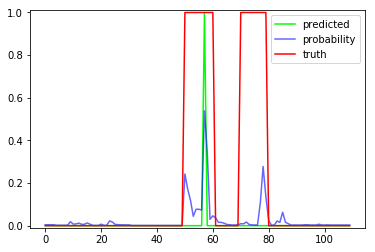

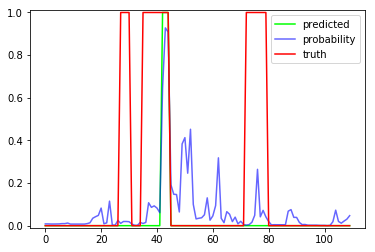

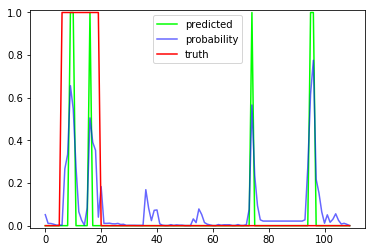

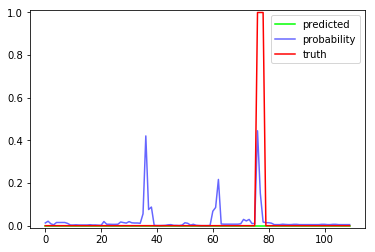

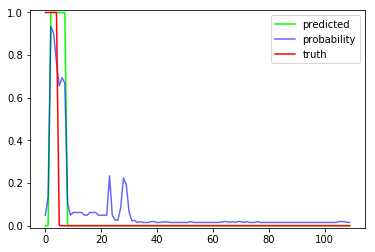

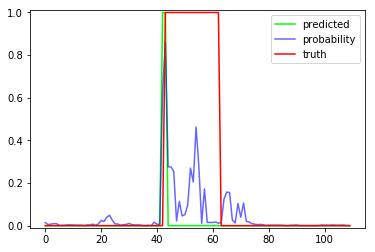

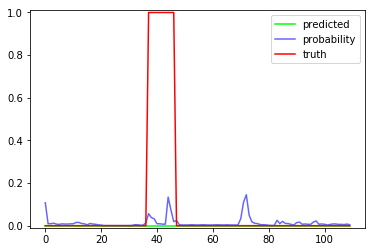

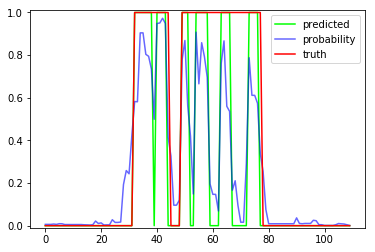

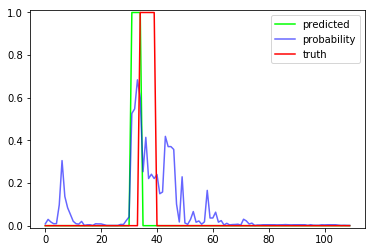

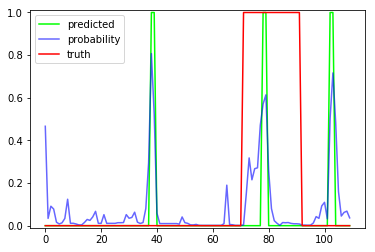

In [21]:
predictor = RnnPredictor(model)
for _ in range(10):
    plot_proba(np.random.choice(dataset[dataset['IS_LAUGHTER'] == 1]['SNAME']))